<a href="https://colab.research.google.com/github/alexenge/nma-course-content/blob/solutions_alex/tutorials/W0D4_Calculus/student/W0D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Differential Equations
**Week 0, Day 4: Calculus**

**By Neuromatch Academy**

__Content creators:__ John S Butler, Arvind Kumar with help from Rebecca Brady

__Content reviewers:__  Swapnil Kumar, Sirisha Sripada, Matthew McCann, Tessy Tom

__Production editors:__ Matthew McCann, Ella Batty

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
*Estimated timing of tutorial: 45 minutes*

A great deal of neuroscience can be modelled using differential equations, from gating channels to single neurons to a network of neurons to blood flow, to behaviour. A simple way to think about differential equations is they are equations that describe how something changes. 

The most famous of these in neuroscience is the Nobel Prize winning Hodgkin Huxley equation, which describes a neuron by modelling the gating of each axon. But we will not start there; we will start a few steps back.

Differential Equations are mathematical equations that describe how something like population or a neuron changes over time. The reason why differential equations are so useful is they can generalise a process such that one equation can be used to describe many different outcomes.
The general form of a first order differential equation is:

\begin{align*}
\frac{d}{dt}y(t)&=f(t,y(t))\\
\end{align*}

which can be read as "the change in a process $y$ over time $t$ is a function $f$ of time $t$ and itself $y$". This might initially seem like a paradox as you are using a process $y$ you want to know about to describe itself, a bit like the MC Escher drawing of two hands painting [each other](https://en.wikipedia.org/wiki/Drawing_Hands). But that is the beauty of mathematics - this can be solved some of time, and when it cannot be solved exactly we can use numerical methods to estimate the answer (as we will see in the next tutorial). 


In this tutorial, we will see how __differential equations are motivated by observations of physical responses.__ We will break down the population differential equation, then the integrate and fire model, which leads nicely into raster plots and frequency-current curves to rate models.

**Steps:**
- Get an intuitive understanding of a linear population differential equation (humans, not neurons)
- Visualize the relationship between the change in population and the population
- Breakdown the Leaky Integrate and Fire (LIF) differential equation
- Code the exact solution of an LIF for a constant input
- Visualize and listen to the response of the LIF for different inputs


In [1]:
# @title Video 1: Why do we care about differential equations?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1v64y197bW", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="LhX-mUd8lPo", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Setup

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import IPython.display as ipd
from matplotlib import gridspec

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

In [3]:
# @title Plotting Functions

def plot_dPdt(alpha=.3):
  """ Plots change in population over time
    Args:
      alpha: Birth Rate
    Returns:
      A figure two panel figure
      left panel: change in population as a function of population
      right panel: membrane potential as a function of time
  """

  with plt.xkcd():
    time=np.arange(0, 10 ,0.01)
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(1, 2)

    ## dpdt as a fucntion of p
    plt.subplot(gs[0])
    plt.plot(np.exp(alpha*time), alpha*np.exp(alpha*time))
    plt.xlabel(r'Population $p(t)$ (millions)')
    plt.ylabel(r'$\frac{d}{dt}p(t)=\alpha p(t)$')

    ## p exact solution
    plt.subplot(gs[1])
    plt.plot(time, np.exp(alpha*time))
    plt.ylabel(r'Population $p(t)$ (millions)')
    plt.xlabel('time (years)')
    plt.show()


def plot_V_no_input(V_reset=-75):
  """
    Args:
      V_reset: Reset Potential
    Returns:
      A figure two panel figure
      left panel: change in membrane potential as a function of membrane potential
      right panel: membrane potential as a function of time
  """
  E_L=-75
  tau_m=10
  t=np.arange(0,100,0.01)
  V= E_L+(V_reset-E_L)*np.exp(-(t)/tau_m)
  V_range=np.arange(-90,0,1)
  dVdt=-(V_range-E_L)/tau_m

  with plt.xkcd():
    time=np.arange(0, 10, 0.01)
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2)

    plt.subplot(gs[0])
    plt.plot(V_range,dVdt)
    plt.hlines(0,min(V_range),max(V_range), colors='black', linestyles='dashed')
    plt.vlines(-75, min(dVdt), max(dVdt), colors='black', linestyles='dashed')
    plt.plot(V_reset,-(V_reset - E_L)/tau_m, 'o', label=r'$V_{reset}$')
    plt.text(-50, 1, 'Positive')
    plt.text(-50, -2, 'Negative')
    plt.text(E_L - 1, max(dVdt), r'$E_L$')
    plt.legend()
    plt.xlabel('Membrane Potential V (mV)')
    plt.ylabel(r'$\frac{dV}{dt}=\frac{-(V(t)-E_L)}{\tau_m}$')

    plt.subplot(gs[1])
    plt.plot(t,V)
    plt.plot(t[0],V_reset,'o')
    plt.ylabel(r'Membrane Potential $V(t)$ (mV)')
    plt.xlabel('time (ms)')
    plt.ylim([-95, -60])

    plt.show()

## LIF PLOT
def plot_IF(t, V,I,Spike_time):
  """
    Args:
      t  : time
      V  : membrane Voltage
      I  : Input
      Spike_time : Spike_times
    Returns:
      figure with three panels
      top panel: Input as a function of time
      middle panel: membrane potential as a function of time
      bottom panel: Raster plot
  """

  with plt.xkcd():
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(3, 1,  height_ratios=[1, 4, 1])

    # PLOT OF INPUT
    plt.subplot(gs[0])
    plt.ylabel(r'$I_e(nA)$')
    plt.yticks(rotation=45)
    plt.hlines(I,min(t),max(t),'g')
    plt.ylim((2, 4))
    plt.xlim((-50, 1000))

    # PLOT OF ACTIVITY
    plt.subplot(gs[1])
    plt.plot(t,V)
    plt.xlim((-50, 1000))
    plt.ylabel(r'$V(t)$(mV)')

    # PLOT OF SPIKES
    plt.subplot(gs[2])
    plt.ylabel(r'Spike')
    plt.yticks([])
    plt.scatter(Spike_time, 1 * np.ones(len(Spike_time)), color="grey", marker=".")
    plt.xlim((-50, 1000))
    plt.xlabel('time(ms)')
    plt.show()


##    Plotting the differential Equation
def plot_dVdt(I=0):
  """
    Args:
      I  : Input Current
    Returns:
      figure of change in membrane potential as a function of membrane potential
  """

  with plt.xkcd():
    E_L = -75
    tau_m = 10
    V = np.arange(-85, 0, 1)
    g_L = 10.
    fig = plt.figure(figsize=(6, 4))

    plt.plot(V,(-(V-E_L) + I*10) / tau_m)
    plt.hlines(0, min(V), max(V), colors='black', linestyles='dashed')
    plt.xlabel('V (mV)')
    plt.ylabel(r'$\frac{dV}{dt}$')
    plt.show()

In [4]:
# @title Helper Functions

## EXACT SOLUTION OF LIF
def Exact_Integrate_and_Fire(I,t):
  """
    Args:
      I  : Input Current
      t : time
    Returns:
      Spike : Spike Count
      Spike_time : Spike time
      V_exact : Exact membrane potential
  """

  Spike = 0
  tau_m = 10
  R = 10
  t_isi = 0
  V_reset = E_L = -75
  V_exact = V_reset * np.ones(len(t))
  V_th = -50
  Spike_time = []

  for i in range(0, len(t)):

    V_exact[i] = E_L + R*I + (V_reset - E_L - R*I) * np.exp(-(t[i]-t_isi)/tau_m)

    # Threshold Reset
    if V_exact[i] > V_th:
        V_exact[i-1] = 0
        V_exact[i] = V_reset
        t_isi = t[i]
        Spike = Spike+1
        Spike_time = np.append(Spike_time, t[i])

  return Spike, Spike_time, V_exact

---
# Section 1: Population differential equation

In [2]:
# @title Video 2: Population differential equation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1pg41137CU", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="czgGyoUsRoQ", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

This video covers our first example of a differential equation: a differential equation which models the change in population.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

To get an intuitive feel of a differential equations, we will start with a population differential equation, which models the change in population [1], that is human population not neurons, we will get to neurons later. Mathematically it is written like:
\begin{align*}
\\
\frac{d}{dt}\,p(t) &= \alpha p(t),\\
\end{align*}

where $p(t)$ is the population of the world and $\alpha$ is a parameter representing birth rate.

Another way of thinking about the models is that the equation
\begin{align*}
\\
\frac{d}{dt}\,p(t) &= \alpha p(t),\\
\text{can be written as:}\\
\text{"Change in Population"} &= \text{ "Birth rate times Current population."}
\end{align*}

The equation is saying something reasonable maybe not the perfect model but a good start.
</details>

### Think! 1.1: Interpretating the behavior of a linear population equation
Using the plot below of change of population $\frac{d}{dt} p(t) $ as a function of population $p(t)$ with birth-rate $\alpha=0.3$, discuss the following questions:
1. Why is the population differential equation known as a linear differential equation?

2. How does population size affect the rate of change of the population?


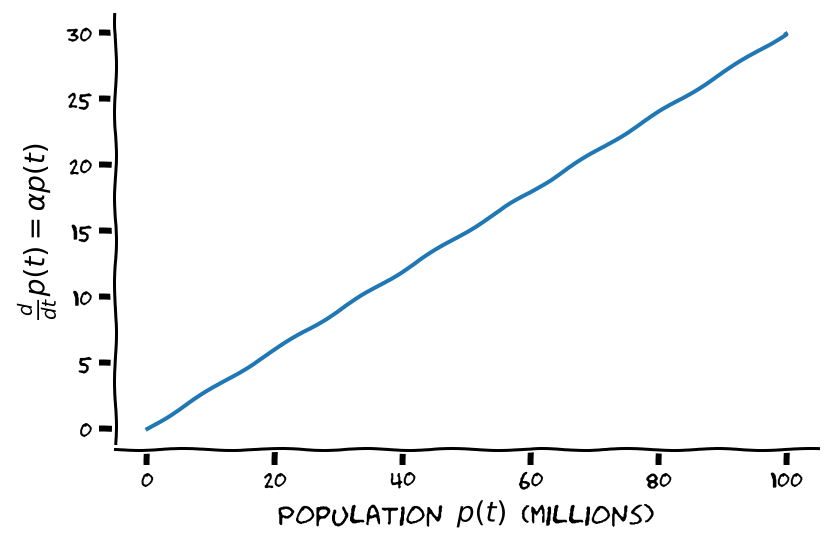

In [5]:
# @markdown Execute the code to plot the rate of change of population as a function of population
p = np.arange(0, 100, 0.1)

with plt.xkcd():

  dpdt = 0.3*p
  fig = plt.figure(figsize=(6, 4))
  plt.plot(p, dpdt)
  plt.xlabel(r'Population $p(t)$ (millions)')
  plt.ylabel(r'$\frac{d}{dt}p(t)=\alpha p(t)$')
  plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial2_Solution_d65c50d6.py)



## Section 1.1: Exact solution of the population equation

### Section 1.1.1: Initial condition
The linear population differential equation is known as an initial value differential equation because we need an initial population value to solve it. Here we will set our initial population at time 0 to 1:

\begin{align*}
&p(0)=1.\\
\end{align*}

Different initial conditions will lead to different answers, but they will not change the differential equation. This is one of the strengths of a differential equation. 

###  Section 1.1.2: Exact Solution
To calculate the exact solution of a differential equation, we must integrate both sides. Instead of numerical integration (as you delved into in the last tutorial), we will first try to solve the differential equations using analytical integration. As with derivatives, we can find analytical integrals of simple equations by consulting [a list](https://en.wikipedia.org/wiki/Lists_of_integrals). We can then get integrals for more complex equations using some mathematical tricks - the harder the equation the more obscure the trick. 

The linear population equation 
\begin{align*}
\frac{d}{dt}\,p(t) &= \alpha p(t),\\\\
p(0)=P_0,\\
\end{align*}
has the exact solution:
\begin{align*}
p(t)&=P_0e^{\alpha t}.\\
\end{align*}

The exact solution written in words is: 

\begin{align*}
\text{"Population"}&=\text{"grows/declines exponentially as a function of time and birth rate"}.\\
\end{align*}

Most differential equations do not have a known exact solution, so in the next tutorial on numerical methods we will show how the solution can be estimated.

A small aside: a good deal of progress in mathematics was due to mathematicians writing taunting letters to each other saying they had a trick that could solve something better than everyone else. So do not worry too much about the tricks.

####  Example Exact Solution of the Population Equation
Let's consider the population differential equation with a birth rate $\alpha=0.3$:

\begin{align*}
\frac{d}{dt}\,p(t) = 0.3 p(t),\\
\text{with the initial condition}\\
p(0)=1.\\
\end{align*}

It has an exact solution 
\begin{align*}
\\
p(t)=e^{0.3 t}.
\end{align*}



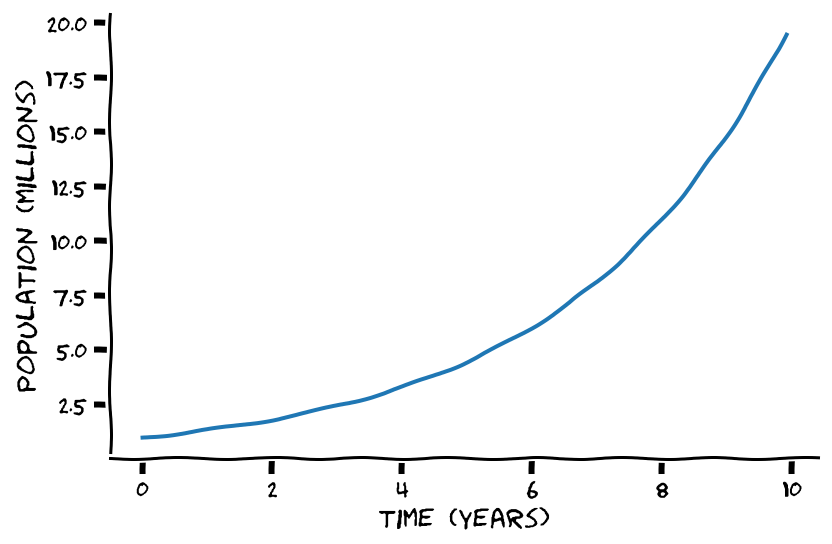

In [6]:
# @markdown Execute code to plot the exact solution
t = np.arange(0, 10, 0.1) # Time from 0 to 10 years in 0.1 steps

with plt.xkcd():

  p = np.exp(0.3 * t)

  fig = plt.figure(figsize=(6, 4))
  plt.plot(t, p)
  plt.ylabel('Population (millions)')
  plt.xlabel('time (years)')
  plt.show()

## Section 1.2: Parameters of the differential equation

*Estimated timing to here from start of tutorial: 12 min*

One of the goals when designing a differential equation is to make it generalisable. Which means that the differential equation will give reasonable solutions for different countries with different birth rates $\alpha$. 


###  Interactive Demo 1.2:  Interactive Parameter Change
Play with the widget to see the relationship between $\alpha$ and the population differential equation as a function of population (left-hand side), and the population solution as a function of time (right-hand side). Pay close attention to the transition point from positive to negative.

How do changing parameters of the population equation affect the outcome?

1. What happens when $\alpha < 0$?
2. What happens when $\alpha > 0$?
3. What happens when $\alpha = 0$?

In [7]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    alpha=widgets.FloatSlider(.3, min=-1., max=1., step=.1, layout=my_layout)
)
def Pop_widget(alpha):
  plot_dPdt(alpha=alpha)
  plt.show()

interactive(children=(FloatSlider(value=0.3, description='alpha', layout=Layout(width='450px'), max=1.0, min=-…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial2_Solution_7cf110c5.py)



The population differential equation is an over-simplification and has some very obvious limitations: 
1. Population growth is not exponential as there are limited number of resources so the population will level out at some point.
2. It does not include any external factors on the populations like weather, predators and preys.

These kind of limitations can be addressed by extending the model.


While it might not seem that the population equation has direct relevance to neuroscience, a similar equation is used to describe the accumulation of evidence for decision making. This is known as the Drift Diffusion Model and you will see in more detail in the Linear System day in Neuromatch (W2D2).


Another differential equation that is similar to the population equation is the Leaky Integrate and Fire model which you may have seen in the python pre-course materials on W0D1 and W0D2. It will turn up later in Neuromatch as well. Below we will delve in the motivation of the differential equation.

---
# Section 2: The leaky integrate and fire model


In [8]:
# @title Video 3: The leaky integrate and fire model
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1rb4y1C79n", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ZfWO6MLCa1s", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

This video covers the Leaky Integrate and Fire model (a linear differential equation which describes the membrane potential of a single neuron).

<details>
<summary> <font color='blue'>Click here for text recap of full LIF equation from video </font></summary>

The Leaky Integrate and Fire Model is a linear differential equation that describes the membrane potential ($V$) of a single neuron which was proposed by Louis Édouard Lapicque in 1907 [2].

The subthreshold membrane potential dynamics of a LIF neuron is described by
\begin{align}
\tau_m\frac{dV}{dt} = -(V-E_L) + R_mI\,
\end{align}


where $\tau_m$ is the time constant, $V$ is the membrane potential,  $E_L$ is the resting potential, $R_m$ is membrane resistance, and $I$ is the external input current. 

</details>

In the next few sections, we will break down the full LIF equation and then build it back up to get an intuitive feel of the different facets of the differential equation.


## Section 2.1: LIF without input

*Estimated timing to here from start of tutorial: 18 min*

As seen in the video, we will first model an LIF neuron without input, which results in the equation:

\begin{align}
\frac{dV}{dt} &= \frac{-(V-E_L)}{\tau_m}.\\
\end{align}

where $\tau_m$ is the time constant, $V$ is the membrane potential, and $E_L$ is the resting potential.

<details>
<summary> <font color='blue'>Click here for further details (from video) </font></summary>

Removing the input gives the equation

\begin{align}
\tau_m\frac{dV}{dt} &= -V+E_L,\\
\end{align}

which can be written in words as:

\begin{align}
\begin{matrix}\text{"Time constant multiplied by the} \\ \text{change in membrane potential"}\end{matrix}&=\begin{matrix}\text{"Minus Current} \\ \text{membrane potential"} \end{matrix}+
\begin{matrix}\text{"resting potential"}\end{matrix}.\\
\end{align}


The equation can be re-arranged to look even more like the population equation:

\begin{align}
\frac{dV}{dt} &= \frac{-(V-E_L)}{\tau_m}.\\
\end{align}
</details>


### Think! 2.1: Effect on membrane potential $V$ on the LIF model

The plot the below shows the change in membrane potential $\frac{dV}{dt}$ as a function of membrane potential $V$ with the parameters set as:
* `E_L = -75`
* `V_reset = -50`
* `tau_m = 10.`

1. What is the effect on $\frac{dV}{dt}$ when $V>-75$ mV?
2. What is the effect on $\frac{dV}{dt}$ when $V<-75$ mV
3. What is the effect on $\frac{dV}{dt}$ when $V=-75$ mV?

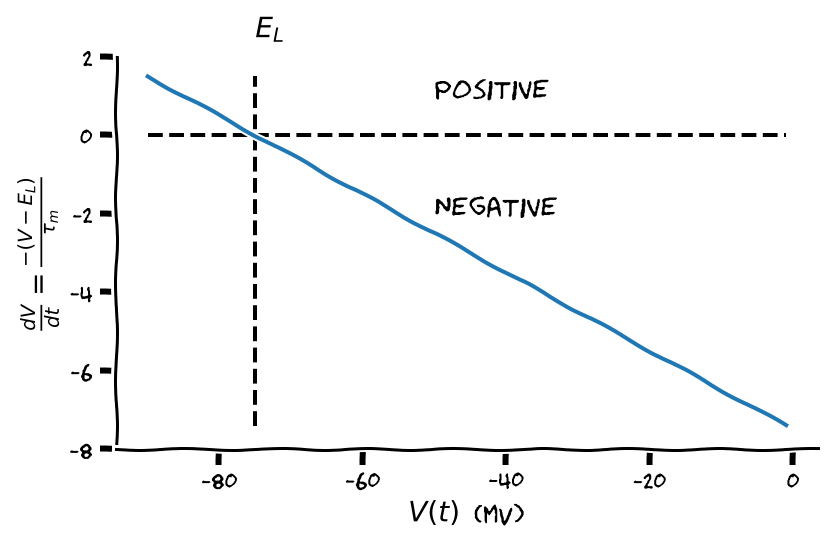

In [9]:
# @markdown Make sure you execute this cell to plot the relationship between dV/dt and V
# Parameter definition
E_L = -75
tau_m = 10

# Range of Values of V
V = np.arange(-90, 0, 1)
dV = -(V - E_L) / tau_m

with plt.xkcd():

  fig = plt.figure(figsize=(6, 4))
  plt.plot(V, dV)
  plt.hlines(0, min(V), max(V), colors='black', linestyles='dashed')
  plt.vlines(-75, min(dV), max(dV), colors='black', linestyles='dashed')

  plt.text(-50, 1, 'Positive')
  plt.text(-50, -2, 'Negative')
  plt.text(E_L, max(dV) + 1, r'$E_L$')
  plt.xlabel(r'$V(t)$ (mV)')
  plt.ylabel(r'$\frac{dV}{dt}=\frac{-(V-E_L)}{\tau_m}$')
  plt.ylim(-8, 2)
  plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial2_Solution_eab10b2d.py)



### Section 2.1.1: Exact Solution of the LIF model without input
The LIF model has the exact solution:
\begin{align*}
V(t)=&\ E_L+(V_{reset}-E_L)e^{\frac{-t}{\tau_m}}\\
\end{align*}

where $\tau_m$ is the time constant, $V$ is the membrane potential,  $E_L$ is the resting potential, and $V_{reset}$ is the initial membrane potential. 

<details>
<summary> <font color='blue'>Click here for further details (from video) </font></summary>

Similar to the population equation, we need an initial membrane potential at time $0$ to solve the LIF model. 

With this equation 
\begin{align}
\frac{dV}{dt} &= \frac{-(V-E_L)}{\tau_m}\,\\
V(0)&=V_{reset},
\end{align}
where is $V_{reset}$ is called the reset potential.

The LIF model has the exact solution:
\begin{align*}
V(t)=&\ E_L+(V_{reset}-E_L)e^{\frac{-t}{\tau_m}}\\
\text{ which can be written as: }\\
\begin{matrix}\text{"Current membrane} \\ \text{potential}"\end{matrix}=&\text{"Resting potential"}+\begin{matrix}\text{"Reset potential minus resting potential} \\ \text{times exponential with rate one over time constant."}\end{matrix}\\
\end{align*}

</details>

#### Interactive Demo 2.1.1: Initial Condition $V_{reset}$
This exercise is to get an intuitive feel of how the different initial conditions $V_{reset}$ impacts the differential equation of the LIF and the exact solution for the equation:

\begin{align}
\frac{dV}{dt} &= \frac{-(V-E_L)}{\tau_m}\,\\
\end{align}
with the parameters set as:
* `E_L = -75,`
* `tau_m = 10.`

The panel on the left-hand side plots the change in membrane potential $\frac{dV}{dt}$ as a function of membrane potential $V$ and right-hand side panel plots the exact solution $V$ as a function of time $t,$ the green dot in both panels is the reset potential $V_{reset}$.

Pay close attention to when $V_{reset}=E_L=-75$mV.

1. How does the solution look with initial values of $V_{reset} < -75$?
2. How does the solution look with initial values of $V_{reset} > -75$?
3. How does the solution look with initial values of $V_{reset} = -75$?



In [10]:
#@markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
  V_reset=widgets.FloatSlider(-77., min=-91., max=-61., step=2,
                              layout=my_layout)
)

def V_reset_widget(V_reset):
  plot_V_no_input(V_reset)

interactive(children=(FloatSlider(value=-77.0, description='V_reset', layout=Layout(width='450px'), max=-61.0,…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial2_Solution_66938503.py)



## Section 2.2: LIF with input
*Estimated timing to here from start of tutorial: 24 min*

We will re-introduce the input $I$ and membrane resistance $R_m$ giving the original equation:

\begin{align}
\tau_m\frac{dV}{dt} = -(V-E_L) + \color{blue}{R_mI}\,
\end{align}

The input can be other neurons or sensory information.

### Interactive Demo 2.2: The Impact of Input
The interactive plot below manipulates $I$ in the differential equation.

- With increasing input, how does the $\frac{dV}{dt}$ change? How would this impact the solution? 

In [11]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
  I=widgets.FloatSlider(3., min=0., max=20., step=2,
                                layout=my_layout)
)

def Pop_widget(I):
  plot_dVdt(I=I)
  plt.show()

interactive(children=(FloatSlider(value=3.0, description='I', layout=Layout(width='450px'), max=20.0, step=2.0…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial2_Solution_fba302c0.py)



### Section 2.2.1: LIF exact solution

The LIF with a constant input has a known exact solution:
\begin{align*}
V(t)=&\ E_L+R_mI+(V_{reset}-E_L-R_mI)e^{\frac{-t}{\tau_m}}\\
\text{which is written as:}\\
\begin{matrix}\text{"Current membrane} \\ \text{potential"}\end{matrix}=&\text{"Resting potential"}+\begin{matrix}\text{"Reset potential minus resting potential} \\ \text{times exponential with rate one over time constant." }\end{matrix}\\
\end{align*}

The plot below shows the exact solution of the membrane potential with the parameters set as:
* `V_reset = -75,`
* `E_L = -75,`
* `tau_m = 10,`
* `R_m = 10,`
* `I = 10.`

Ask yourself, does the result make biological sense? If not, what would you change? We'll delve into this in the next section

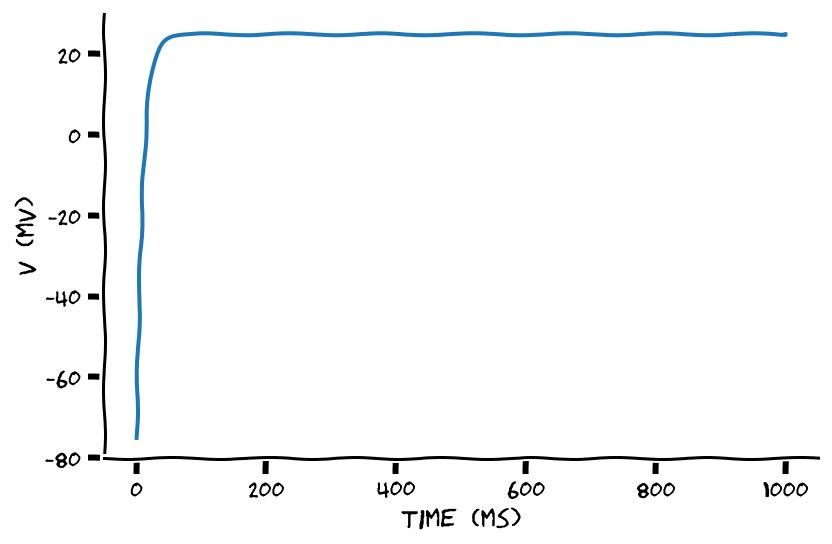

In [12]:
# @markdown Make sure you execute this cell to see the exact solution
dt = 0.5
t_rest = 0

t = np.arange(0, 1000, dt)

tau_m = 10
R_m = 10
V_reset = E_L = -75

I = 10

V = E_L + R_m*I + (V_reset - E_L - R_m*I) * np.exp(-(t)/tau_m)

with plt.xkcd():

  fig = plt.figure(figsize=(6, 4))
  plt.plot(t,V)
  plt.ylabel('V (mV)')
  plt.xlabel('time (ms)')
  plt.show()

## Section 2.3: Maths is one thing, but neuroscience matters

*Estimated timing to here from start of tutorial: 30 min*

In [13]:
# @title Video 4: Adding firing to the LIF
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1gX4y1P7pZ", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="rLQk-vXRaX0", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

This video first recaps the introduction of input to the leaky integrate and fire model and then delves into how we add spiking behavior (or firing) to the model.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

While the mathematics of the exact solution is exact, it is not biologically valid as a neuron spikes and definitely does not plateau at a very positive value.

To model the firing of a spike, we must have a threshold voltage $V_{th}$ such that if the voltage $V(t)$ goes above it, the neuron spikes
$$V(t)>V_{th}.$$
We must record the time of spike $t_{isi}$  and count the number of spikes
$$t_{isi}=t, $$
$$𝑆𝑝𝑖𝑘𝑒=𝑆𝑝𝑖𝑘𝑒+1.$$
Then reset the membrane voltage $V(t)$
$$V(t_{isi} )=V_{Reset}.$$

To take into account the spike the exact solution becomes:
\begin{align*}
V(t)=&\ E_L+R_mI+(V_{reset}-E_L-R_mI)e^{\frac{-(t-t_{isi})}{\tau_m}},&\qquad V(t)<V_{th} \\
V(t)=&V_{reset},&\qquad V(t)>V_{th}\\
Spike=&Spike+1,&\\
t_{isi}=&t,\\
\end{align*}
while this does make the neuron spike, it introduces a discontinuity which is not as elegant mathematically as it could be, but it gets results so that is good.
</detail>

### Interactive Demo 2.3.1: Input on spikes
This exercise show the relationship between firing rate and the Input for exact solution `V` of the LIF:
$$
V(t)=\ E_L+R_mI+(V_{reset}-E_L-R_mI)e^{\frac{-(t-t_{isi})}{\tau_m}},
$$
with the parameters set as:
* `V_reset = -75,`
* `E_L = -75,`
* `tau_m = 10,`
* `R_m = 10.`


Below is a figure with three panels; 
* the top panel is the input, $I,$
* the middle panel is the membrane potential $V(t)$. To illustrate the spike, $V(t)$ is set to $0$ and then reset to $-75$ mV when there is a spike. 
* the bottom panel is the raster plot with each dot indicating a spike.

First, as electrophysiologist normally listen to spikes when conducting experiments, listen to the music of the firing rate for a single value of $I$. (Note the audio doesn't work in some browsers so don't worry about it if you can't hear anything) 

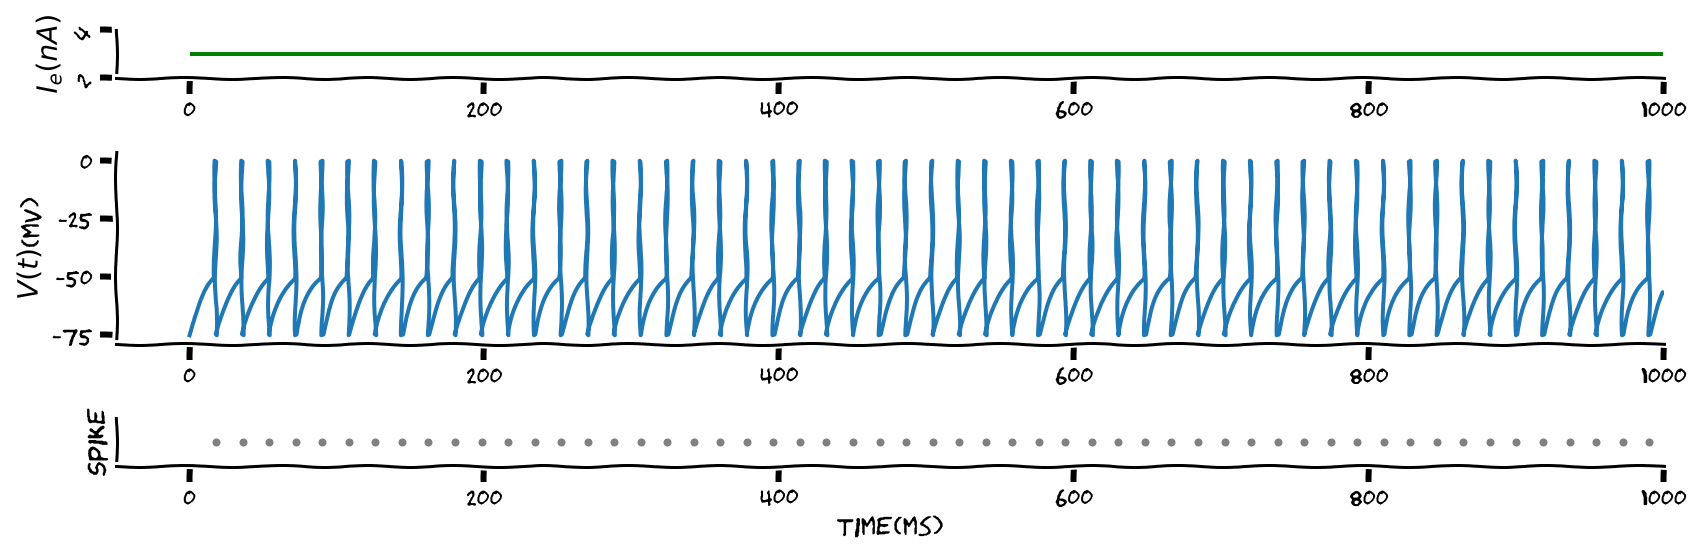

In [16]:
# @markdown Make sure you execute this cell to be able to hear the neuron
I = 3
t = np.arange(0, 1000, dt)
Spike, Spike_time, V = Exact_Integrate_and_Fire(I, t)

plot_IF(t, V, I, Spike_time)
ipd.Audio(V, rate=len(V))

Manipulate the input into the LIF to see the impact of input on the firing pattern (rate).

*  What is the effect of $I$ on spiking?
* Is this biologically valid?

In [17]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
  I=widgets.FloatSlider(3, min=2.0, max=4., step=.1,
                              layout=my_layout)
)

def Pop_widget(I):
  Spike, Spike_time, V = Exact_Integrate_and_Fire(I, t)
  plot_IF(t, V, I, Spike_time)

interactive(children=(FloatSlider(value=3.0, description='I', layout=Layout(width='450px'), max=4.0, min=2.0),…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial2_Solution_f60cec6c.py)



## Section 2.4 Firing Rate as a function of Input

*Estimated timing to here from start of tutorial: 38 min*

The firing frequency of a neuron plotted as a function of current is called an input-output curve (F–I curve). It is also known as a transfer function, which you came across in the previous tutorial. This function is one of the starting points for the rate model, which extends from modelling single neurons to the firing rate of a collection of neurons. 

By fitting this to a function, we can start to generalise the firing pattern of many neurons, which can be used to build rate models. This will be discussed later in Neuromatch. 

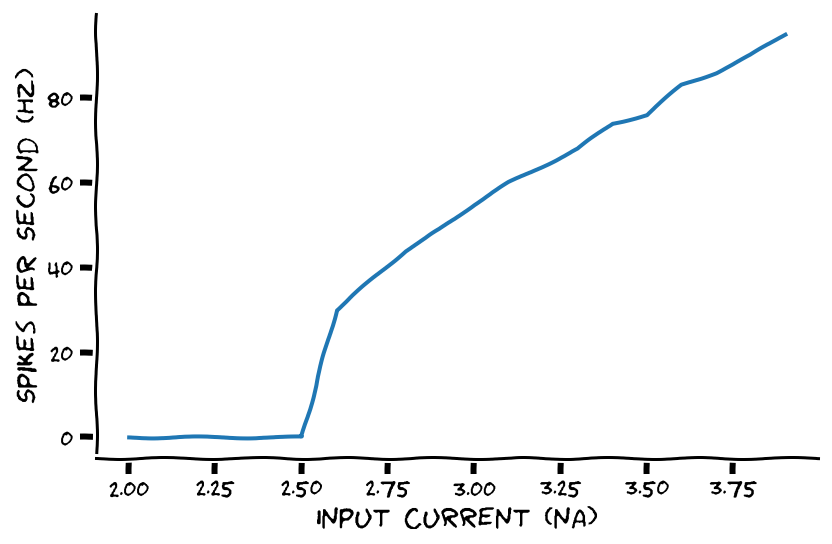

In [18]:
# @markdown *Execture this cell to visualize the FI curve*
I_range = np.arange(2.0, 4.0, 0.1)
Spike_rate = np.ones(len(I_range))

for i, I in enumerate(I_range):
  Spike_rate[i], _, _ = Exact_Integrate_and_Fire(I, t)

with plt.xkcd():
  fig = plt.figure(figsize=(6, 4))
  plt.plot(I_range,Spike_rate)
  plt.xlabel('Input Current (nA)')
  plt.ylabel('Spikes per Second (Hz)')
  plt.show()

The LIF model is a very nice differential equation to start with in computational neuroscience as it has been used as a building block for many papers that simulate neuronal response.

__Strengths  of LIF model:__
+ Has an exact solution;
+ Easy to interpret;
+ Great to build network of neurons.

__Weaknesses of the LIF model:__
- Spiking is a discontinuity;
- Abstraction from biology;
- Cannot generate different spiking patterns.



---
# Summary

*Estimated timing of tutorial: 45 min*

In [19]:
# @title Video 5: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1jV411x7t9", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="VzwLAW5p4ao", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In this tutorial, we have seen two differential equations, the population differential equations and the leaky integrate and fire model.


We learned about:
* The motivation for differential equations.
* An intuitive relationship between the solution and the form of the differential equation.
* How different parameters of the differential equation impact the solution.
* The strengths and limitations of the simple differential equations.


---
# Links to Neuromatch Days

Differential equations turn up in a number of different Neuromatch days:
* The LIF model is discussed in more details in Model Types (Week 1 Day 1) and Real Neurons (Week 2 Day 3).
* Drift Diffusion model which is a differential equation for decision making is discussed in Linear Systems (Week 2 Day 2).
* Systems of differential equations are discussed in Linear Systems (Week 2 Day 2) and Dynamic Networks (Week 2 Day 4).


---
# References 
1. Lotka, A. L, (1920)   Analytical note on certain rhythmic  relations inorganic  systems.Proceedings of the National Academy of Sciences,6(7):410–415,1920.

2. Brunel N, van Rossum MC. Lapicque's 1907 paper: from frogs to integrate-and-fire. Biol Cybern. 2007 Dec;97(5-6):337-9. doi: 10.1007/s00422-007-0190-0. Epub 2007 Oct 30. PMID: 17968583.



# Bibliography
1. Dayan, P., & Abbott, L. F. (2001). Theoretical neuroscience: computational and mathematical modeling of neural systems. Computational Neuroscience Series.
2. Strogatz, S. Nonlinear dynamics and chaos: with applications to physics, biology, chemistry, and engineering (studies in nonlinearity), Westview Press; 2 edition (29 July 2014)

## Supplemental Popular Reading List
1. Lindsay, G. (2021). Models of the Mind: How Physics, Engineering and Mathematics Have Shaped Our Understanding of the Brain. Bloomsbury Publishing.
2. Strogatz, S. (2004). Sync: The emerging science of spontaneous order. Penguin UK.

## Popular Podcast
1. Strogatz, S. (Host). (2020-), Joy of X  https://www.quantamagazine.org/tag/the-joy-of-x/ Quanta Magazine
